# 肤色检测

In [2]:
import numpy as np
%matplotlib  inline
import cv2
import matplotlib.pyplot as plt

In [3]:
src = cv2.cvtColor(cv2.imread('../datas/face.jpg'),cv2.COLOR_BGR2RGB)

In [62]:
def get_hsv_mask(img, debug=False):
#     assert isinstance(img, numpy.ndarray), 'image must be a numpy array'
#     assert img.ndim == 3, 'skin detection can only work on color images'
#     logger.debug('getting hsv mask')

    lower_thresh = np.array([0, 50, 0], dtype=np.uint8)
    upper_thresh = np.array([120, 150, 255], dtype=np.uint8)
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    msk_hsv = cv2.inRange(img_hsv, lower_thresh, upper_thresh)

    msk_hsv[msk_hsv < 128] = 0
    msk_hsv[msk_hsv >= 128] = 1

#     if debug:
#         scripts.display('input', img)
#         scripts.display('mask_hsv', msk_hsv)

    return msk_hsv.astype(float)


def get_rgb_mask(img, debug=False):
#     assert isinstance(img, numpy.ndarray), 'image must be a numpy array'
#     assert img.ndim == 3, 'skin detection can only work on color images'
#     logger.debug('getting rgb mask')

    lower_thresh = np.array([45, 52, 108], dtype=np.uint8)
    upper_thresh = np.array([255, 255, 255], dtype=np.uint8)

    mask_a = cv2.inRange(img, lower_thresh, upper_thresh)
    mask_b = 255 * ((img[:, :, 2] - img[:, :, 1]) / 20)
    mask_c = 255 * ((np.max(img, axis=2) - np.min(img, axis=2)) / 20)
    # msk_rgb = cv2.bitwise_and(mask_c, cv2.bitwise_and(mask_a, mask_b))
    mask_d = np.bitwise_and(np.uint64(mask_a), np.uint64(mask_b))
    msk_rgb = np.bitwise_and(np.uint64(mask_c), np.uint64(mask_d))

    msk_rgb[msk_rgb < 128] = 0
    msk_rgb[msk_rgb >= 128] = 1

#     if debug:
#         scripts.display('input', img)
#         scripts.display('mask_rgb', msk_rgb)

    return msk_rgb.astype(float)


def get_ycrcb_mask(img, debug=False):
#     assert isinstance(img, numpy.ndarray), 'image must be a numpy array'
#     assert img.ndim == 3, 'skin detection can only work on color images'
#     logger.debug('getting ycrcb mask')

    lower_thresh = np.array([90, 100, 130], dtype=np.uint8)
    upper_thresh = np.array([230, 120, 180], dtype=np.uint8)

    img_ycrcb = cv2.cvtColor(img, cv2.COLOR_RGB2YCR_CB)
    msk_ycrcb = cv2.inRange(img_ycrcb, lower_thresh, upper_thresh)

    msk_ycrcb[msk_ycrcb < 128] = 0
    msk_ycrcb[msk_ycrcb >= 128] = 1

#     if debug:
#         scripts.display('input', img)
#         scripts.display('mask_ycrcb', msk_ycrcb)

    return msk_ycrcb.astype(float)


def grab_cut_mask(img_col, mask, debug=False):
#     assert isinstance(img_col, numpy.ndarray), 'image must be a numpy array'
#     assert isinstance(mask, numpy.ndarray), 'mask must be a numpy array'
#     assert img_col.ndim == 3, 'skin detection can only work on color images'
# #     assert mask.ndim == 2, 'mask must be 2D'

    kernel = np.ones((50, 50), np.float32) / (50 * 50)
    dst = cv2.filter2D(mask, -1, kernel)
    dst[dst != 0] = 255
    free = np.array(cv2.bitwise_not(dst), dtype=np.uint8)

#     if debug:
#         scripts.display('not skin', free)
#         scripts.display('grabcut input', mask)

    grab_mask = np.zeros(mask.shape, dtype=np.uint8)
    grab_mask[:, :] = 2
    grab_mask[mask == 255] = 1
    grab_mask[free == 255] = 0

    if np.unique(grab_mask).tolist() == [0, 1]:
#         logger.debug('conducting grabcut')
        bgdModel = np.zeros((1, 65), np.float64)
        fgdModel = np.zeros((1, 65), np.float64)

        if img_col.size != 0:
            mask, bgdModel, fgdModel = cv2.grabCut(img_col, grab_mask, None, bgdModel, fgdModel, 5,
                                                   cv2.GC_INIT_WITH_MASK)
            mask = np.where((mask == 2) | (mask == 0), 0, 1).astype(np.uint8)
#         else:
#             logger.warning('img_col is empty')

    return mask


def closing(mask):
#     assert isinstance(mask, numpy.ndarray), 'mask must be a numpy array'
#     assert mask.ndim == 2, 'mask must be a greyscale image'
#     logger.debug("closing mask of shape {0}".format(mask.shape))

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=2)

    return mask


def process(img, thresh=0.5, debug=False):
#     assert isinstance(img, numpy.ndarray), 'image must be a numpy array'
#     assert img.ndim == 3, 'skin detection can only work on color images'
#     logger.debug("processing image of shape {0}".format(img.shape))

    mask_hsv = get_hsv_mask(img, debug=debug)
    mask_rgb = get_rgb_mask(img, debug=debug)
    mask_ycrcb = get_ycrcb_mask(img, debug=debug)

    n_masks = 3.0
    mask = (mask_hsv + mask_rgb + mask_ycrcb) / n_masks

    mask[mask < thresh] = 0.0
    mask[mask >= thresh] = 255.0
#     logger.debug('{0}% of the image is skin'.format(int((100.0 / 255.0) * numpy.sum(mask) / mask.size)))

    mask = mask.astype(np.uint8)

    mask = closing(mask)
    mask = grab_cut_mask(img, mask, debug=debug)

    return mask

In [67]:
dst = process(src)

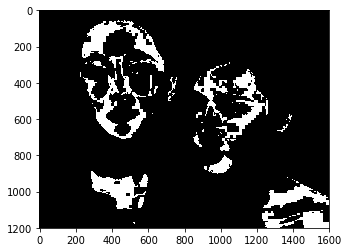

In [68]:
plt.imshow(dst,'gray')

In [69]:
skin_dst = np.zeros_like(src)
skin_dst[dst > 0] = src[dst>0]

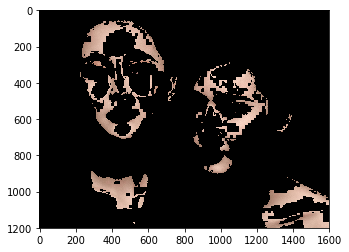

In [70]:
plt.imshow(skin_dst)

In [6]:
def skin_detect2(img):
    frame = img
    lower = np.array([0, 100, 0], dtype="uint8")
    upper = np.array([50,255,255], dtype="uint8")
    # switch to HSV
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    # find mask of pixels within HSV range
    skinMask = cv2.inRange(hsv, lower, upper)
    # denoise
    skinMask = cv2.GaussianBlur(skinMask, (9, 9), 0)
    # kernel for morphology operation
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (4, 4))
    # CLOSE (dilate / erode)
    skinMask = cv2.morphologyEx(skinMask, cv2.MORPH_CLOSE, kernel, iterations = 3)
    # denoise the mask
    skinMask = cv2.GaussianBlur(skinMask, (9, 9), 0)
    # only display the masked pixels
    skin = cv2.bitwise_and(frame, frame, mask = skinMask)
    return skin

In [7]:
dst = skin_detect2(src)

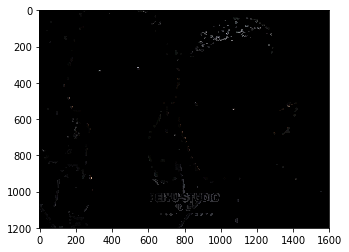

In [8]:
plt.imshow(dst)